## Importar librerías

In [82]:
import pandas as pd
from nltk.corpus import stopwords
import seaborn as sns
import numpy as np
import spacy 
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
import networkx as nx
import cufflinks as cf
import plotly.express as px
from ipywidgets import interact
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

## Data Cleanning

In [83]:
friends = pd.read_csv("friends_quotes.csv")

In [84]:
friends.drop(friends[(friends["season"] == 1) & (friends["episode_number"] == 16)].index,inplace = True) #el episodio 16 no está bien escrapeado

In [85]:
chandler =["CHAN","CHANDLER","Chandler (Stands up and walks to Joey)","Chandle","Chandler (nearly weeping)","Chandler (to Joey)", "Chandler (to Monica)", "Chandlers"]
monica =["Young Monica","Fake Monica", "Fat Monica", "MONICA","MNCA","MOnica","Monic","Monica (to Ross)","Monica about to have a heart attack","Monica to Amy","Monica to Emma","Monica to Ross","Monica (reads a form in her lap)"] 
joey = ["Fat Joey","JOEY","Joe","Joey (staring at the cake)","Joey (to Rachel)","Joey (to Ross)"]
phoebe = ["PHOE","PHOEBE","Phoeb","Phoebe (to Mike)","Phoebe (to Rachel)","Phoebe (walking to Ross carrying a black leather jacket)","Phoebe (watching the food on the table)","Phoebe looks down"]
rachel = ["Big nosed rachel","RACH","RACHEL","RAHCEL", "Rache","Rachel (crying)","Rachel (leaving)","Rachel (on the phone)","Rachel (she flips the coin)","Rachel opens their door","Rachel to Emma","Rachel (as Monica)","Racel"]
ross = ["ROSS","Ross (on the verge of tears)","Ross (stops recording)","Ross (to Emma)","Ross first has a look of 'huh' then changes it to sarcastic happy","Ross looks down","Ross makes some sort of sound to let us know it hurt","Ross starts playing with a plate","Ross starts talking over her 'do you remember' line","Ross to Monica","Ross with a look of wondering how long this is going to go on on his face","Young Ross","ros"]

In [86]:
friends["author"] = friends["author"].apply(lambda x: "Chandler" if x in chandler else x).apply(lambda x: "Phoebe" if x in phoebe else x).apply(lambda x: "Joey" if x in joey else x).apply(lambda x: "Rachel" if x in rachel else x).apply(lambda x: "Ross" if x in ross else x).apply(lambda x: "Monica" if x in monica else x).str.strip().str.lower().str.replace("ms. geller","mrs. geller").str.replace("judy","mrs. geller").str.replace("frank jr","frank").str.capitalize()

In [87]:
friends.drop(friends[(friends["author"] == "All")].index,inplace = True)

## Characters with more Lines/Season

In [88]:
@interact(Season = list(friends["season"].unique()))
def more_common_characters(Season):
    more_common_characters = friends[friends.season == Season]["author"].value_counts().head(9).index.to_list()
    sns.set(rc={'figure.figsize':(7,7), 'axes.facecolor':'black'}, font_scale=1.5)
    palette = ["#ed1111","#f4f723","#23c6f7"]
    sns.countplot(y='author', data=friends[(friends.author.isin(more_common_characters)) & (friends.season == Season)], order = more_common_characters, palette = palette)

interactive(children=(Dropdown(description='Season', options=(1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.…

## Season 1: Conversations between the most common characters

In [89]:
more_common_characters_season_1 = friends[friends.season == 1.0]["author"].value_counts().head(9).index.to_list()
more_common_characters_season_1

['Ross',
 'Monica',
 'Rachel',
 'Chandler',
 'Joey',
 'Phoebe',
 'Carol',
 'Susan',
 'Janice']

In [90]:
season1_df = friends[(friends.season == 1.0) & friends["author"].isin(more_common_characters_season_1)]
season1_df

,author,episode_number,episode_title,quote,quote_order,season
0,Monica,1.0,Monica Gets A Roommate,There's nothing to tell! He's just some guy I ...,0.0,1.0
1,Joey,1.0,Monica Gets A Roommate,"C'mon, you're going out with the guy! There's ...",1.0,1.0
2,Chandler,1.0,Monica Gets A Roommate,"All right Joey, be nice. So does he have a hum...",2.0,1.0
3,Phoebe,1.0,Monica Gets A Roommate,"Wait, does he eat chalk?",3.0,1.0
4,Phoebe,1.0,Monica Gets A Roommate,"Just, 'cause, I don't want her to go through w...",4.0,1.0
...,...,...,...,...,...,...
5970,Ross,24.0,Rachel Finds Out,"Oh, hey, hey, I got that.",250.0,1.0
5972,Ross,24.0,Rachel Finds Out,No problem. I cannot wait for you to meet my f...,252.0,1.0
5974,Ross,24.0,Rachel Finds Out,Yeah.,254.0,1.0
5976,Ross,24.0,Rachel Finds Out,"No, no, they will. I just... uh...",256.0,1.0


In [91]:
season1_df.to_excel(r"./season1_df.xlsx", index = False)

In [92]:
season_1_main_characters = pd.read_excel("season1_df_modified.xlsx")

In [93]:
conversation_weights = season_1_main_characters["Conversation"].value_counts(normalize = True)
conversation_weights

Ross, Rachel        0.171171
Ross, Carol         0.114114
Chandler, Joey      0.113113
Rachel, Monica      0.086086
Chandler, Phoebe    0.083083
Ross, Joey          0.079079
Susan, Ross         0.065065
Monica, Joey        0.062062
Chandler, Janice    0.054054
Phoebe, Rachel      0.038038
Phoebe, Monica      0.033033
Ross, Chandler      0.031031
Joey, Phoebe        0.022022
Susan, Carol        0.020020
Chandler, Monica    0.016016
Chandler, Rachel    0.009009
Ross, Phoebe        0.002002
Janice, Joey        0.001001
Name: Conversation, dtype: float64

In [94]:
conversation_weights = pd.DataFrame(conversation_weights).reset_index()

In [95]:
conversation_weights[["A","B"]] = conversation_weights["index"].str.split(",",expand=True)

In [96]:
conversation_weights["A"] = conversation_weights["A"].str.strip()
conversation_weights["B"] = conversation_weights["B"].str.strip()

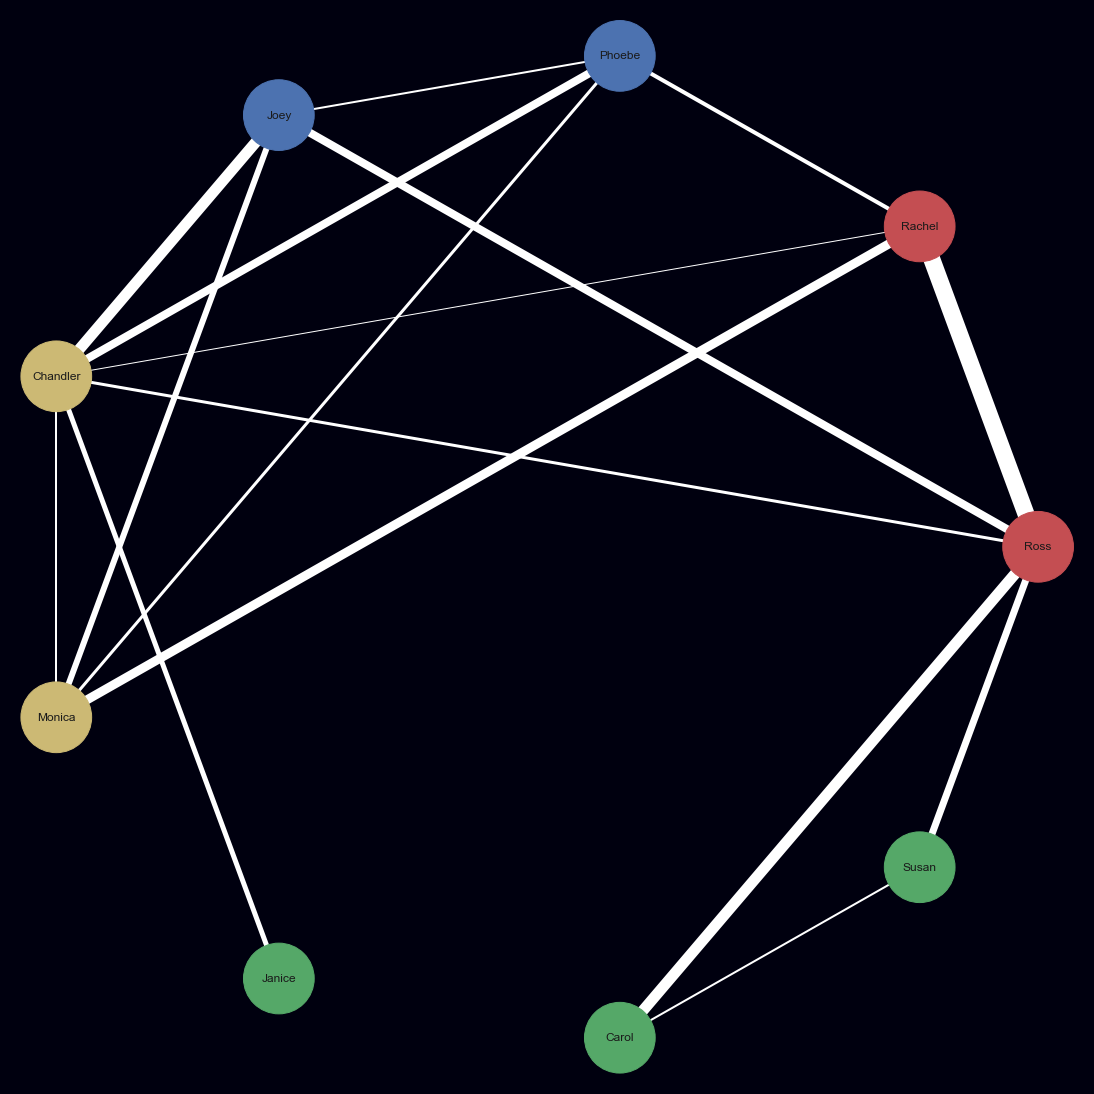

In [97]:
plt.rcParams["figure.figsize"] = (15,15)

G = nx.Graph()
G.add_node("Ross", color='r')
G.add_node("Rachel", color='r')
G.add_node("Phoebe", color='b')
G.add_node("Joey", color='b')
G.add_node("Chandler", color='y')
G.add_node("Monica", color='y')
G.add_node("Janice", color='g')
G.add_node("Carol", color='g')
G.add_node("Susan", color='g')

for i in range(len(conversation_weights)):
    G.add_edge(conversation_weights["A"][i],conversation_weights["B"][i], weight=round(conversation_weights["Conversation"][i]*100))

colors_nodes = nx.get_node_attributes(G,'color').values()
weights = nx.get_edge_attributes(G,'weight').values()
pos = nx.circular_layout(G)

fig = plt.figure()
nx.draw(G, pos, 
        edge_color="white", 
        width=list(weights),
        with_labels=True,
        node_color= colors_nodes, node_size=5000)
fig.set_facecolor("#00000F")

## Guests Stars over the 10 seasons

In [102]:
guest_stars = pd.read_excel("Guest_Stars_DF.xlsx")

In [103]:
guest_stars = pd.pivot_table(guest_stars,index=["Actor","season"],
                values = ["quote"],           
               aggfunc='count',fill_value=0)

In [104]:
guest_stars.reset_index(inplace = True)

In [105]:
fig = px.bar(guest_stars, x="season", y="quote", color = "Actor", title="Guest_Stars")
fig.show()

## Sentiment Analysis

### Cleanning

In [106]:
main_characters = ["Ross", "Joey","Chandler","Phoebe","Rachel","Monica"]

In [108]:
friends= friends[friends.author.isin(main_characters)].drop(columns=['episode_number', 'episode_title', "quote_order"]).reset_index(drop = True)
friends

,author,quote,season
0,Monica,There's nothing to tell! He's just some guy I ...,1.0
1,Joey,"C'mon, you're going out with the guy! There's ...",1.0
2,Chandler,"All right Joey, be nice. So does he have a hum...",1.0
3,Phoebe,"Wait, does he eat chalk?",1.0
4,Phoebe,"Just, 'cause, I don't want her to go through w...",1.0
...,...,...,...
49992,Chandler,"Oh, it's gonna be okay.",10.0
49993,Rachel,(crying) Do you guys have to go to the new hou...,10.0
49994,Monica,We got some time.,10.0
49995,Rachel,"Okay, should we get some coffee?",10.0


In [109]:
friends["quote"] = friends["quote"].str.replace("\(([^)]+)\)","").str.strip().str.lower().str.split("[.|!|?]", expand = False)
friends["quote"]

0        [there's nothing to tell,  he's just some guy ...
1        [c'mon, you're going out with the guy,  there'...
2        [all right joey, be nice,  so does he have a h...
3                              [wait, does he eat chalk, ]
4        [just, 'cause, i don't want her to go through ...
                               ...                        
49992                           [oh, it's gonna be okay, ]
49993    [do you guys have to go to the new house right...
49994                                 [we got some time, ]
49995                  [okay, should we get some coffee, ]
49996                                     [sure,  where, ]
Name: quote, Length: 49997, dtype: object

In [110]:
friends = friends.explode("quote")

In [111]:
friends.reset_index(drop = True, inplace = True)

In [112]:
scene = friends[friends["quote"].str.contains("scene:")].index.to_list()

In [113]:
friends = friends.drop(friends.index[scene])

In [114]:
friends["quote"] = friends["quote"].str.replace("[^a-zA-Z' ]","")

In [115]:
friends.reset_index(drop = True, inplace = True)

In [116]:
indexes = []
for i in range(len(friends["quote"])):
    if len(friends["quote"][i]) == 0:
        indexes.append(i)

In [117]:
friends = friends.drop(friends.index[indexes]).reset_index(drop = True)

In [118]:
friends["quote"] = friends["quote"].str.strip()

In [119]:
friends['number_words'] = friends['quote'].str.count(' ') + 1

In [120]:
one_word = friends[friends["number_words"] == 1].index.to_list()

In [121]:
friends = friends.drop(friends.index[one_word]).reset_index(drop = True)

In [122]:
friends["quote"] = friends["quote"].str.replace("'\s","")

In [123]:
friends["quote"] = friends["quote"].str.replace("'cause","because").str.replace("you know","y'know").str.replace("you are","you're").str.replace("come on","c'mon").str.replace("'kay","okay").str.replace("'em","them").str.replace("doin'","doing").str.replace("(ya)","you").str.replace("lemme","let me").str.replace("gonna", "going to").str.replace("'", "")

In [124]:
friends.drop('number_words', axis='columns', inplace=True)

In [125]:
friends.head()

,author,quote,season
0,Monica,theres nothing to tell,1.0
1,Monica,hes just some guy i work with,1.0
2,Joey,cmon youre going out with the guy,1.0
3,Joey,theres gotta be something wrong with him,1.0
4,Chandler,all right joey be nice,1.0


## CountVectorizer (most spoken words)

In [126]:
vectorizer = CountVectorizer(min_df = 0.0002, ngram_range =(3,3))
matrix = vectorizer.fit_transform(friends["quote"])
matrix

<71548x903 sparse matrix of type '<class 'numpy.int64'>'
	with 30993 stored elements in Compressed Sparse Row format>

In [127]:
matrix.shape

(71548, 903)

In [128]:
y = friends.iloc[:, 0].values

In [129]:
counts = pd.DataFrame(matrix.toarray(),index = list(y),
                      columns=vectorizer.get_feature_names())

In [131]:
counts = counts.groupby(counts.index).sum()

In [132]:
counts.T.columns

Index(['Chandler', 'Joey', 'Monica', 'Phoebe', 'Rachel', 'Ross'], dtype='object')

In [142]:
counts.T["Joey"].sort_values(ascending = False).head(20)

im going to       104
going to be        97
what are you       60
oh my god          57
youre going to     51
going to do        45
no no no           44
what do you        44
not going to       40
check it out       37
dont want to       35
are you doing      33
do you think       32
going to go        27
were going to      27
talk to you        26
days of our        26
going to have      26
want you to        25
going to get       24
Name: Joey, dtype: int64

## TfidfVectorizer (most spoken words by two people)

In [136]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 0.0002, ngram_range =(3,3))

In [137]:
X = tfidf.fit_transform(friends["quote"])
y = friends.iloc[:, 0].values

In [139]:
counts2 = pd.DataFrame(X.toarray(),index = list(y),
                      columns=tfidf.get_feature_names())
counts2 = counts2.groupby(counts2.index).sum()

In [143]:
counts2.T["Joey"].sort_values(ascending = False).head(15)

im going to       57.345227
oh my god         53.227403
going to be       51.587350
what are you      36.516981
check it out      31.715823
youre going to    30.861968
no no no          27.154339
what do you       26.376158
do you think      24.761189
going to do       23.226338
dont want to      23.080978
are you doing     21.512586
not going to      21.251351
want you to       18.619246
days of our       18.579231
Name: Joey, dtype: float64

## Código Extra

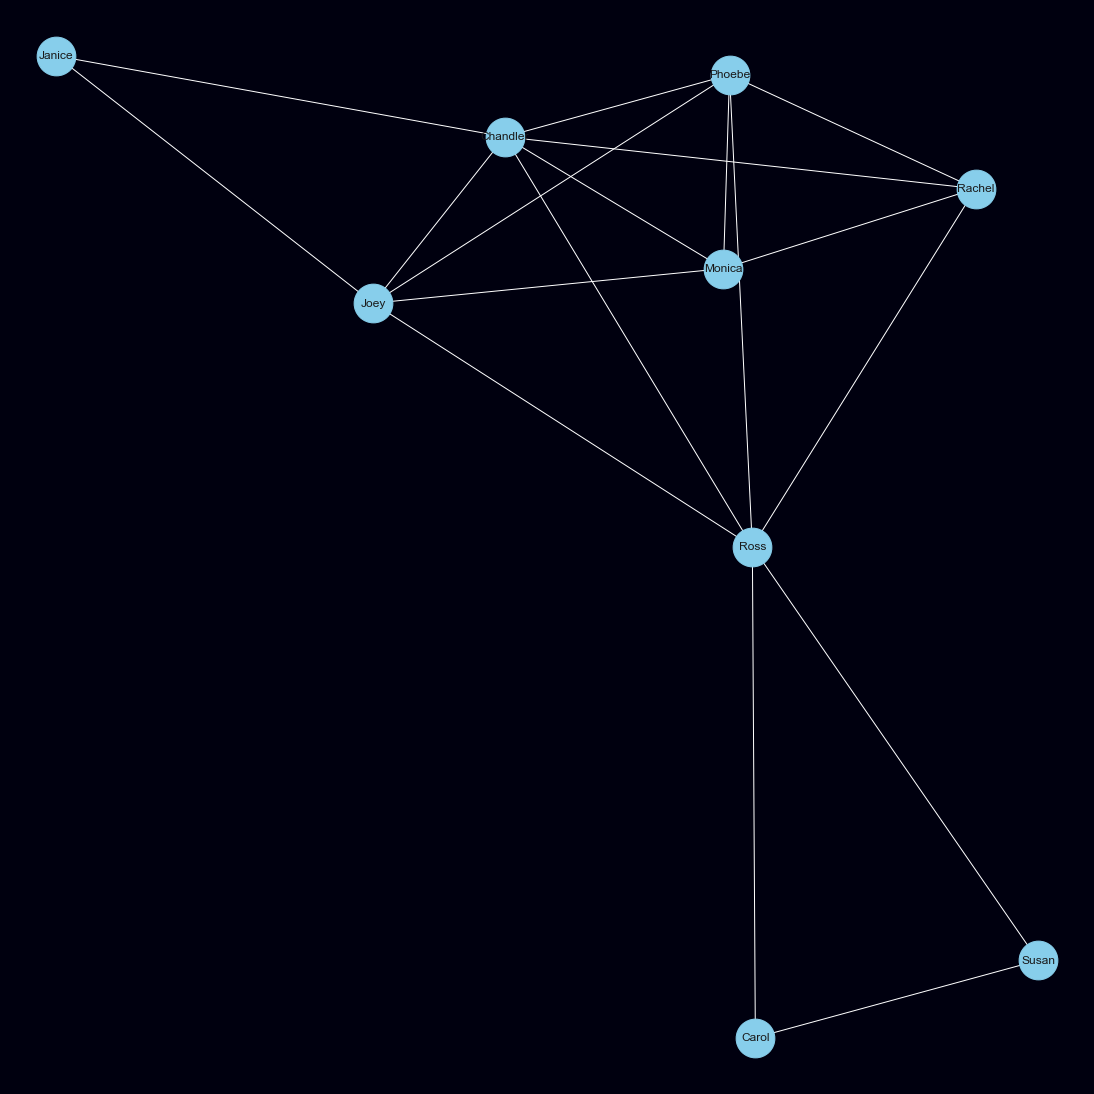

In [144]:
G=nx.from_pandas_edgelist(conversation_weights, 'A', 'B', create_using=nx.Graph() )
 
# Custom the nodes:
fig = plt.figure()
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_color='white')
fig.set_facecolor("#00000F")